# Trading Earnings Volatility

## Background

Quarterly earning announcements can cause potentially extreme moves in individual equities as companies under/over perform relative to expectation. These are previously announced events with known times, giving both day traders and large institutions the opportunity to place volatility and directional bets in the options marketplace, capitalizing on market reaction and the sentiment to the report.

To highlight this, we can look at the recent underlying volatility surrounding AMZN and GOOG earnings at the start of 2022, with Alphabet reporting after the market close on 2/1 and AMZN reporting after the market close on 2/2.

GOOG rallied from 2757 to 2960, a gain of 7.3% between the earnings report and the close on 2/2. (GOOGL very similar performance)
Amazon dropped from 3012 to 2776, losing more than 8% between the earnings report and the close on 2/3.

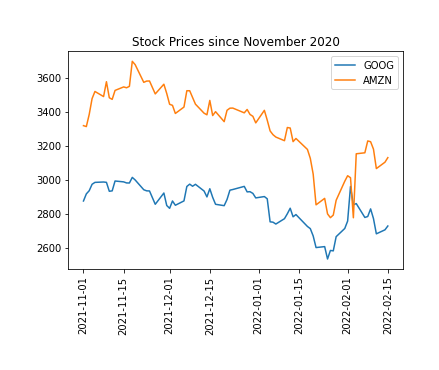

In [1]:
from IPython.display import Image
Image('GOOG_AMZN.png')

## Hypothesis

Stocks experience higher than average realized volatility around quarterly earnings announcements.


The average realized volatility of an individual equity stock through its historical earnings reports relative to its baseline performance is predictive of how much we would expect it to move on an upcoming earnings press release.


If the shortest dated at the money options for an issuer is priced on an implied volatility higher than our prediction for realized volatility going into an earnings, there is a positive expected value in selling the at the money straddle. If the straddle is priced below our prediction for realized volatility, there is a positive expected value position in buying the straddle. 


## Data

We will be using the WRDS OptionsMetrics database to get our data. Specifically, 'OptionMetrics - Historical Volatility' and 'OptionMetrics - Option Prices'.

### Required:
1. Historical earnings dates
2. Daily realized volatility calculations
3. Daily option implied volatilities
4. Daily market close bid/ask prices for the nearest term 50d call and put option

### May Want to Consider:
5. Daily option volumes
6. Earnings data vs expectations

## Strategy Execution

Select a subset of companies that we expect would be a good candidate for this volatility trading strategy. We will select stocks with liquid options markets with earnings announcements that have sparked increased options trading speculation. We also need to select companies that have enough of an earnings history to form a prediction.

For each stock selected:
    1. Compare realized volatility on and the day after earnings announcements to their average realized volatility in the training data set
    2. Calculate an expectation for realized volatility for the future earnings dates in a testing data set and compare it to the implied volatility of the at the money straddle in the day's preceeding the earnings dates.
    3. Construct a sizing curve depending on the difference between implied volatility vs expected realized volatility. Depending on the difference, trade up to 10k notional buying or selling the at the money straddle at the close price BBO.
    4. Close out our straddle position T+1 after earnings date.
    


## Analysis and Data

In [2]:
import quandl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
quandl.ApiConfig.api_key = 'bULWv51MebBBGL56KGys'

#### Select historical adjusted close prices for companies with liquid options markets

In [3]:
#Our option price data ends on 12/31/20 so we will end our analysis on that date.
start = '2015-01-01'
end = '2020-12-31'

tickers = ['GOOG', 'AMZN', 'SNAP', 'MSFT', 'FB', 'TSLA', 'NVDA', 'JPM', 'AVGO', 'VZ']

adj_close = quandl.get_table("QUOTEMEDIA/PRICES", 
                        ticker = tickers,  
                        qopts = { 'columns': ['ticker', 'date', 'adj_close']},  
                        date = { 'gte': start, 'lte': end}, 
                        paginate = True)

adj_close.head()

,ticker,date,adj_close
None,,,
0,VZ,2020-12-31,55.537089
1,VZ,2020-12-30,54.960449
2,VZ,2020-12-29,55.593808
3,VZ,2020-12-28,55.754511
4,VZ,2020-12-24,55.622167


#### 

### Financial statement filing date

In [4]:
# earnings dates (FC/FILING_DATE)
zacks_fc = quandl.get_table('ZACKS/FC', 
                    per_end_date = { 'gte': start, 'lte': end },
                    ticker = tickers, 
                    paginate=True)

In [5]:
# quarterly report filing dates
filing_dates = zacks_fc[zacks_fc['per_type'] == 'Q'][['ticker', 'filing_date']]
filing_dates

,ticker,filing_date
None,,
6,AMZN,2015-04-24
7,AMZN,2015-07-24
8,AMZN,2015-10-23
9,AMZN,2016-01-29
10,AMZN,2016-04-29
...,...,...
292,VZ,2020-02-21
293,VZ,2020-04-27
294,VZ,2020-07-28


#### Historical option data

In [6]:
# this is limited to options with expiry less than 15 days from current date.
option_data = pd.read_csv('data/OptionMetrics.csv.gz', sep = ',')

In [7]:
# match date format of quandl data
option_data['date'] = option_data.apply(lambda row: row.date.replace('/', '-', 2), axis = 1)
option_data['exdate'] = option_data.apply(lambda row: row.exdate.replace('/', '-', 2), axis = 1)

In [8]:
# strike_price = strike * 1000
option_data.head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,optionid,ticker,index_flag,issuer,exercise_style
0,2015-01-02,2015-01-09,C,235000,71.90,75.55,0,0.919228,0.986198,106179177,AMZN,0,AMAZON.COM INC.,A
1,2015-01-02,2015-01-09,C,240000,67.00,70.85,0,0.955372,0.975301,106179178,AMZN,0,AMAZON.COM INC.,A
2,2015-01-02,2015-01-09,C,245000,61.85,65.35,0,0.695843,0.992689,106134398,AMZN,0,AMAZON.COM INC.,A
3,2015-01-02,2015-01-09,C,250000,57.15,60.45,0,0.771536,0.978447,106134399,AMZN,0,AMAZON.COM INC.,A
4,2015-01-02,2015-01-09,C,255000,52.00,55.45,0,0.673865,0.981649,106134400,AMZN,0,AMAZON.COM INC.,A


### Analysis

In [592]:
class Earnings_strat():
    
    def __init__(self, filing_dates_df, option_data_df, adj_close_df, vola_window):
        self.filing_dates_df = filing_dates_df
        self.option_data_df = option_data_df
        self.adj_close_df = adj_close_df
        self.vola_window = vola_window
        self.data_cleaned = False
        
    def __calc_rolling_vola(self):
        
        close_vola_df = pd.DataFrame()
        
        for t in self.adj_close_df.ticker.unique():
            df = self.adj_close_df[self.adj_close_df['ticker'] == t]
            df = (df['adj_close'].rolling(self.vola_window).std() * np.sqrt(252)) / df['adj_close']
            close_vola_df = pd.concat([close_vola_df, df], axis = 0)
            
        close_vola_df=close_vola_df.rename(columns={0:"vola_{}day".format(self.vola_window)})
        close_vola_df = pd.concat([self.adj_close_df, close_vola_df], axis = 1)
        
        return close_vola_df
    
    # this function returns the 50 delta calls and puts for exdate immediately after filing_date
    def __filter_opts(self):
                
        self.opt_expiry = {}
        result = pd.DataFrame(columns = ['ticker', 'filing_date', 'exdate'])
        
        # find option expiring after earnings date
        for s in self.option_data_df['ticker'].unique():
        
            filing = pd.DataFrame(self.filing_dates_df[self.filing_dates_df['ticker'] == s])
            options = pd.DataFrame(self.option_data_df[self.option_data_df['ticker'] == s])
    
            options['exdate'] = pd.to_datetime(options['exdate'])
            filing['filing_date'] = pd.to_datetime(filing['filing_date'])
        
            # want options that expire after filing date
            filing['filing_date'] = filing['filing_date'] + pd.Timedelta('1 days')
        
            filing_exdate = []
        
            for d in filing['filing_date']:
                try:
                    date = options[options['exdate'] >= d].head(1).exdate.item()
                    
                    result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
                                          ignore_index = True)
                except ValueError: # error raised if no option expiry after final filing date
                    continue

        result['filing_date'] = pd.to_datetime(result['filing_date'])
        result['exdate'] = pd.to_datetime(result['exdate'])
        self.filing_dates_df = pd.DataFrame(result)
        
        self.option_data_df['exdate'] = pd.to_datetime(self.option_data_df['exdate'])
        
        # merge on exdate just after filing_dates
        self.option_data_df = pd.merge(self.option_data_df, self.filing_dates_df,
                                       on = ['ticker', 'exdate'])
        
        # get options closest to delta=50 for each expiry
        res = pd.DataFrame()
        for s in self.option_data_df['ticker'].unique():
            
            call_d, put_d = {}, {}
            
            df = self.option_data_df[self.option_data_df['ticker'] == s]
        
            df = df.set_index('date')
        
            for d in df.index.unique():
                call_i = (abs(df.loc[d]['delta'] - 0.5)).argmin()
                put_i = (abs(df.loc[d]['delta'] + 0.5)).argmin()
                call_d[d] = df.loc[d].iloc[call_i]
                put_d[d] = df.loc[d].iloc[put_i]
            
            calls = pd.DataFrame(call_d).transpose()
            puts = pd.DataFrame(put_d).transpose()
        
            calls.index = pd.to_datetime(calls.index)
            puts.index = pd.to_datetime(puts.index)
            
            temp = pd.concat([calls, puts], axis = 0)
            res = pd.concat([res, temp], axis = 0)
        
        return res
    
    # clean_data returns the daily 50 delta call and put for each symbol
    # and includes the next filing_date, adj_close, and rolling realized vol
    def clean_data(self):
        close_vola_df = self.__calc_rolling_vola()
        cleaned_opts = self.__filter_opts()
        
        cleaned_opts = cleaned_opts.reset_index()
        cleaned_opts = cleaned_opts.rename(columns = {'index':'date'})
        
        self.atm_opts = pd.merge(cleaned_opts, close_vola_df, on=['date', 'ticker'])
        
        self.data_cleaned = True
        return self.atm_opts
    
    def __is_weekend(self, day):
    
        if (day.weekday() == 6):
            return day + pd.Timedelta(days = 1)
        elif (day.weekday() == 5):
            return day + pd.Timedelta(days = 2)
        else:
            return day
    
    # returns df with bid/ask 'days' days before earnings and 1 day after earnings
    # as well as implied and realized vol 'days' days before earnings
    # so we can use this df to find a correlation between the two
    def vol_vs_straddle(self, days):
        
        if (not self.data_cleaned):
            print("must run clean_data function first")
            return
        
        opts = pd.DataFrame(self.atm_opts)
        
        opts['days_to_filing'] = opts['filing_date'] - opts['date']
        opts['filing_day_of_week'] = opts['filing_date'].dt.weekday
        opts = opts[opts['days_to_filing'] == '{} days'.format(days)]
        opts['day_after_filing'] = opts['filing_date'] + pd.Timedelta(days=1)
        
        opts = opts.rename(columns = {'date': 'today', 'day_after_filing': 'date'})
        opts['adj_date'] = opts.apply(lambda row: self.__is_weekend(row['date']), axis = 1)
        
        opt_prices = pd.DataFrame(self.option_data_df[['date', 'optionid', 'best_bid', 'best_offer']])
        opt_prices = opt_prices.rename(columns = {'best_bid': 'post_bid', 'best_offer': 'post_offer'})
        opts = opts.drop(['date'], axis=1)
        opts = opts.rename(columns={'adj_date':'date'})
        
        o = pd.merge(opts, opt_prices, on = ['optionid', 'date'])
        
        agg_f = {'exdate': 'first', 'strike_price': 'first', 'best_bid': 'sum', 'best_offer': 'sum',
        'volume': 'mean', 'impl_volatility': 'mean', 'filing_date': 'first', 'adj_close': 'first',
        'post_bid': 'sum', 'post_offer': 'sum', 'vola_7day': 'mean', 'date':'first'}
        out = o.groupby(['today', 'ticker']).aggregate(agg_f)
        out['vola_diff'] = out['impl_volatility'] - out['vola_7day']
        
        out = out.rename(columns={'date': 'date_after_filing'})
        
        return out
        
    
    

In [593]:
strat = Earnings_strat(filing_dates, option_data, adj_close, vola_window = 7)

In [594]:
opts = strat.clean_data()

/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/

/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/

/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/

/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/

/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/

/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/1904282268.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/

In [595]:
vol_straddle = strat.vol_vs_straddle(1)

In [596]:
# post_bid and post_offer are prices 1 day after earnings
# best_bid and best_offer are prices n days before earnings
vol_straddle

exdate strike_price best_bid best_offer  volume  \
today      ticker                                                       
2015-03-11 AVGO   2015-03-20       125000      5.3       5.75    68.5   
2015-04-24 AMZN   2015-05-01       445000     12.8       13.7  3639.0   
2015-04-28 VZ     2015-05-01        50500     0.52       0.58   470.5   
2015-05-05 JPM    2015-05-08        64500      0.9       0.93  1319.0   
2015-05-11 TSLA   2015-05-15       240000     7.65        7.9  5129.0   
...                      ...          ...      ...        ...     ...   
2020-10-30 AMZN   2020-11-06      3045000    181.0      183.1   345.5   
           FB     2020-11-06       265000    15.85       16.5  4944.0   
           GOOG   2020-11-06      1625000     85.2       89.0   125.5   
2020-11-02 JPM    2020-11-06       100000     4.64       4.91  2132.5   
2020-12-18 AVGO   2020-12-24       435000     10.0       12.1    94.5   

                   impl_volatility filing_date    adj_close  post_bid  \
today      ticker                                                       
2015-03-11 AVGO           0.346724  2015-03-12   103.074317      4.40   
2015-04-24 AMZN           0.269426  2015-04-25   445.100000     10.84   
2015-04-28 VZ             0.150072  2015-04-29    37.304675      0.32   
2015-05-05 JPM            0.195522  2015-05-06    53.518530      0.60   
2015-05-11 TSLA           0.387746  2015-05-12    47.898000      5.75   
...                            ...         ...          ...       ...   
2020-10-30 AMZN           0.541560  2020-10-31  3036.150000    142.50   
           FB             0.552104  2020-10-31   263.110000     13.10   
           GOOG           0.485428  2020-10-31  1621.010000     62.30   
2020-11-02 JPM            0.570512  2020-11-03    97.216263      2.49   
2020-12-18 AVGO           0.248311  2020-12-19   422.177903      9.05   

                   post_offer  vola_7day date_after_filing  vola_diff  
today      ticker                                                      
2015-03-11 AVGO          5.15   0.386748        2015-03-13  -0.040024  
2015-04-24 AMZN         11.27   0.315323        2015-04-27  -0.045897  
2015-04-28 VZ            0.38   0.103453        2015-04-30   0.046619  
2015-05-05 JPM           0.64   0.162280        2015-05-07   0.033242  
2015-05-11 TSLA          6.02   0.222684        2015-05-13   0.165062  
...                       ...        ...               ...        ...  
2020-10-30 AMZN        144.60   0.701356        2020-11-02  -0.159796  
           FB           13.60   0.875570        2020-11-02  -0.323466  
           GOOG         69.20   0.671748        2020-11-02  -0.186320  
2020-11-02 JPM           2.62   1.144216        2020-11-04  -0.573704  
2020-12-18 AVGO          9.85   0.111717        2020-12-21   0.136594  

[110 rows x 13 columns]